<div class="alert alert-success">
    
## Домашнее задание №5: сверточный классификатор.

### Общая информация

Дату мягкого и жесткого дедлайна см. на стр. в `notion`

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

**Если вы отправляете своё решение после мягкого дедлайна просим отписывать проверяющему в личные сообщения в тг о том, что загрузили решение в гугл форму.**

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдача задания после жесткого дедлайна приведет к умножению вашего результата на коэффициент 0.4, что значительно снижает итоговый результат. 

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Обсуждать задачи вместе можно, но тогда напишите, с кем обсуждали задачу. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. 

**Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.**

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [27]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=8)
    
    return train_loader, val_loader, test_loader
    

In [28]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

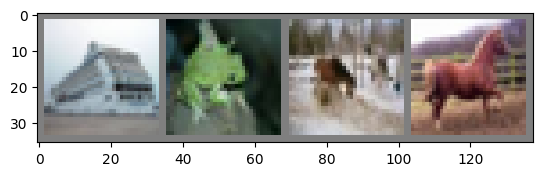

ship frog horse horse


In [29]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [30]:
n_classes = 10


class BasicBlockNet(nn.Module):

    def __init__(self):
        super(BasicBlockNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.shortcut = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=1, stride=1, bias=False)

        self.avg_pool = nn.AvgPool2d(kernel_size=8)

        self.fc = nn.Linear(32 * 4 * 4, n_classes)

    def forward(self, x):
        skip_connection_res = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += skip_connection_res
        out = self.relu(out)


        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)


        out = self.fc(out)

        return out

In [31]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (avg_pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [32]:
# Количество параметров в модели
sum(p.numel() for p in net.parameters() if p.requires_grad)

15434

Проверим, что выход сети имеет корректную размерность:

In [33]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [35]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [36]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss_log.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / target.size(0)
        acc_log.append(acc)
        
    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / target.size(0)
        acc_log.append(acc)

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, model_name='model.pt', scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}")

        current_lr = optimizer.param_groups[0]['lr']
        print(f" learning rate: {current_lr}\n")
        
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

    torch.save(net, model_name)

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [37]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, model_name='baseline_lr01.pt')

Epoch 0
 train loss: 1.4637714408651348, train acc: 0.4791394620005223
 val loss: 1.2284870923833644, val acc: 0.5652482269503545
 learning rate: 0.1

Epoch 1
 train loss: 1.1457245990606724, train acc: 0.6000220357795769
 val loss: 1.0511777238642916, val acc: 0.6324911347517731
 learning rate: 0.1

Epoch 2
 train loss: 1.028433048637955, train acc: 0.6403883194045443
 val loss: 1.0452001049163493, val acc: 0.629122340425532
 learning rate: 0.1

Epoch 3
 train loss: 0.982027124334297, train acc: 0.6592411530425699
 val loss: 0.9705964217794703, val acc: 0.663674645390071
 learning rate: 0.1

Epoch 4
 train loss: 0.9433925686850191, train acc: 0.6723810067902847
 val loss: 0.9496468262469515, val acc: 0.6669769503546098
 learning rate: 0.1

Epoch 5
 train loss: 0.913042728109813, train acc: 0.6833458474797597
 val loss: 1.0122637104480825, val acc: 0.6485150709219859
 learning rate: 0.1

Epoch 6
 train loss: 0.8918964492337578, train acc: 0.6887323713763384
 val loss: 0.984844730255451

Посчитайте точность на тестовой выборке:

In [38]:
# <your code here>
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 68.73009554140127 %


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

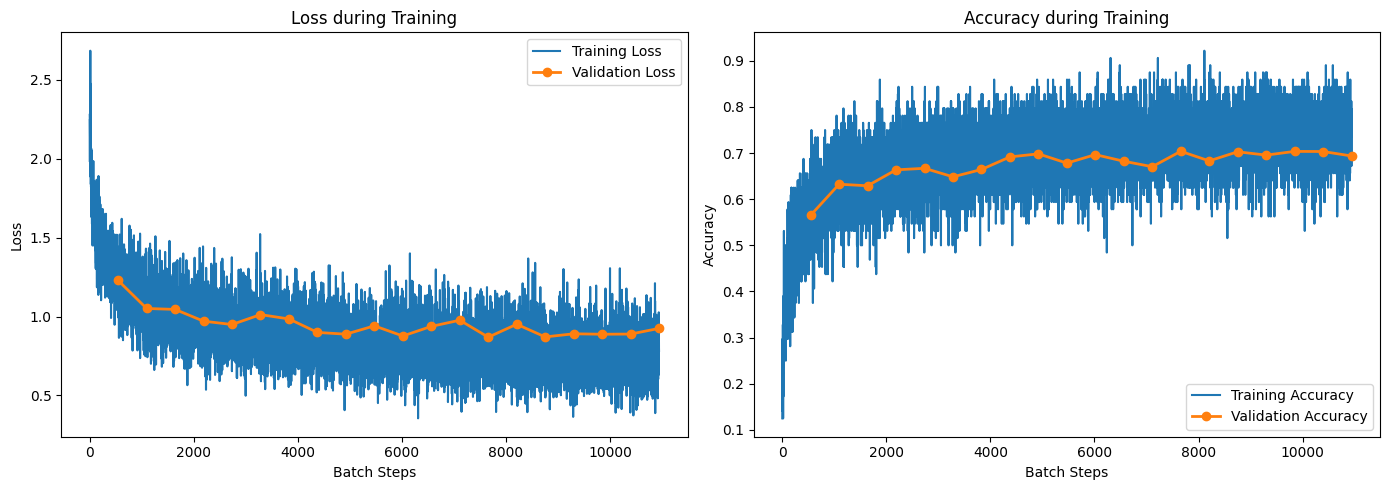

In [39]:
batch_steps = list(range(1, len(train_loss_log) + 1))
epoch_steps = list(range(1, len(val_loss_log) + 1))

val_steps_scaled = [x * (len(train_loss_log) / len(val_loss_log)) for x in epoch_steps]


plt.figure(figsize=(14, 5))

# Функция потерь
plt.subplot(1, 2, 1)
plt.plot(batch_steps, train_loss_log, label='Training Loss')
plt.plot(val_steps_scaled, val_loss_log, label='Validation Loss', linewidth=2, marker='o')
plt.xlabel('Batch Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss during Training')

# Точность классификации
plt.subplot(1, 2, 2)
plt.plot(batch_steps, train_acc_log, label='Training Accuracy')
plt.plot(val_steps_scaled, val_acc_log, label='Validation Accuracy', linewidth=2, marker='o')
plt.xlabel('Batch Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy during Training')


plt.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С первой недели модуля Вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [40]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_sch_mslr.pt')

Epoch 0
 train loss: 1.4946832963056058, train acc: 0.46661579394097674
 val loss: 1.3061387883855942, val acc: 0.5364804964539007
 learning rate: 0.1



/home/maxim/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1
 train loss: 1.2109817774247862, train acc: 0.5727139919038913
 val loss: 1.1954017568141857, val acc: 0.5678191489361702
 learning rate: 0.1

Epoch 2
 train loss: 1.0622092944176584, train acc: 0.6262895011752415
 val loss: 1.1124928289271416, val acc: 0.6229166666666668
 learning rate: 0.1

Epoch 3
 train loss: 0.9968087633959336, train acc: 0.6510389462000522
 val loss: 1.055729099283827, val acc: 0.6267952127659574
 learning rate: 0.1

Epoch 4
 train loss: 0.9565608884996208, train acc: 0.6692674327500653
 val loss: 0.9874998762252483, val acc: 0.6605718085106383
 learning rate: 0.1

Epoch 5
 train loss: 0.9245319831741793, train acc: 0.6789876599634369
 val loss: 0.9787938878891316, val acc: 0.6660904255319149
 learning rate: 0.1

Epoch 6
 train loss: 0.9029570801057589, train acc: 0.6863778075215461
 val loss: 0.9680381719102251, val acc: 0.6636303191489362
 learning rate: 0.1

Epoch 7
 train loss: 0.8910802974343518, train acc: 0.6911155001305823
 val loss: 0.93402213695

Посчитайте точность на тестовой выборке:

In [41]:
# <your code here>
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 68.3718152866242 %


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [42]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, model_name='model_nosch.pt')

Epoch 0
 train loss: 1.8309977499179038, train acc: 0.35875065291198743
 val loss: 1.6208331737112491, val acc: 0.43785460992907804
 learning rate: 0.001

Epoch 1
 train loss: 1.5496071627196708, train acc: 0.45496539566466443
 val loss: 1.4698011195406, val acc: 0.4865691489361702
 learning rate: 0.001

Epoch 2
 train loss: 1.4325618678516618, train acc: 0.497629113345521
 val loss: 1.3866706939453775, val acc: 0.5132313829787234
 learning rate: 0.001

Epoch 3
 train loss: 1.3597333025888725, train acc: 0.5240598067380517
 val loss: 1.3378566868761752, val acc: 0.5289893617021276
 learning rate: 0.001

Epoch 4
 train loss: 1.307617786815441, train acc: 0.543186047270828
 val loss: 1.2761191276793784, val acc: 0.551706560283688
 learning rate: 0.001

Epoch 5
 train loss: 1.2612976201927422, train acc: 0.5590028401671454
 val loss: 1.2448234659560182, val acc: 0.5661790780141843
 learning rate: 0.001

Epoch 6
 train loss: 1.2226739364524646, train acc: 0.5726731849046748
 val loss: 1.20

In [43]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 66.71974522292994 %


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [44]:
# Scheduler: ExponentialLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_sch_exp.pt')

Epoch 0
 train loss: 1.5058870363496992, train acc: 0.4653466962653434
 val loss: 1.3144370020704066, val acc: 0.5351507092198582
 learning rate: 0.1

Epoch 1
 train loss: 1.157465006468283, train acc: 0.5930317968137896
 val loss: 1.1349063373626547, val acc: 0.601950354609929
 learning rate: 0.00484800431750456

Epoch 2
 train loss: 1.1112068215933317, train acc: 0.6118519848524419
 val loss: 1.0963103238572465, val acc: 0.6197030141843971
 learning rate: 0.007329825956595111

Epoch 3
 train loss: 1.0742151704523202, train acc: 0.6229188430399581
 val loss: 1.064571779585899, val acc: 0.6292331560283688
 learning rate: 0.008011054312728852

Epoch 4
 train loss: 1.043270847806111, train acc: 0.6347773570122748
 val loss: 1.0493781980047834, val acc: 0.6322030141843971
 learning rate: 0.008618431227050234

Epoch 5
 train loss: 1.0124106452931434, train acc: 0.6466848393836511
 val loss: 1.0354669687595772, val acc: 0.6377216312056737
 learning rate: 0.008925279023812805

Epoch 6
 train

In [45]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 67.83439490445859 %


In [46]:
# Scheduler: CosineAnnealingLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", 0.1, 2)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_sch_plateau.pt')

Epoch 0
 train loss: 1.5189096526646308, train acc: 0.4565283037346566
 val loss: 1.3377933190224018, val acc: 0.5252216312056738
 learning rate: 0.1

Epoch 1
 train loss: 1.2011236111468326, train acc: 0.5764151867328283
 val loss: 1.1733058472897144, val acc: 0.5954787234042553
 learning rate: 0.1

Epoch 2
 train loss: 1.0699297434887023, train acc: 0.6263874379733612
 val loss: 1.0717714553183697, val acc: 0.6260416666666667
 learning rate: 0.1

Epoch 3
 train loss: 1.0051938221267198, train acc: 0.649149582136328
 val loss: 1.0097765098226832, val acc: 0.6499113475177306
 learning rate: 0.1

Epoch 4
 train loss: 0.9711695643621999, train acc: 0.6633626599634369
 val loss: 0.9406313023668654, val acc: 0.675642730496454
 learning rate: 0.1

Epoch 5
 train loss: 0.9379330784136896, train acc: 0.6739112692609036
 val loss: 0.9673983416658767, val acc: 0.6622340425531915
 learning rate: 0.1

Epoch 6
 train loss: 0.9161440021813024, train acc: 0.6811789958213633
 val loss: 0.937195866665

In [47]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 71.85509554140127 %


In [48]:
# Scheduler: CyclicLR
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.001, 0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_sch_cycle.pt')

Epoch 0
 train loss: 1.8200796023147416, train acc: 0.3632598263254113
 val loss: 1.6150246315814079, val acc: 0.43251329787234044
 learning rate: 0.001

Epoch 1
 train loss: 1.5382654577548152, train acc: 0.45743013841734137
 val loss: 1.4547909087323128, val acc: 0.4852615248226951
 learning rate: 0.0010799437192632775

Epoch 2
 train loss: 1.4130974909941065, train acc: 0.5026483742491512
 val loss: 1.3448749572672742, val acc: 0.5272828014184398
 learning rate: 0.0010720121499822404

Epoch 3
 train loss: 1.3311927765335418, train acc: 0.5322375293810394
 val loss: 1.3009503001862384, val acc: 0.5387632978723405
 learning rate: 0.0010665713103847213

Epoch 4
 train loss: 1.2655929870753664, train acc: 0.5545956842517629
 val loss: 1.2446036866370669, val acc: 0.5612810283687945
 learning rate: 0.0010643970398592378

Epoch 5
 train loss: 1.2135877187552793, train acc: 0.5752236223557065
 val loss: 1.193237766306451, val acc: 0.5835106382978723
 learning rate: 0.0010616078824885497

E

In [49]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 66.95859872611464 %


Your answers here:

**Our answers there:**

Мы привыкли называть это скоростью обучения (learning_rate). 

Мы выбрали: 

`ExponentialLR` - каждую эпоху уменьшает learning rate, умножая на определенную величину гамма, скорость обучения при этом будет значительно снижаться в течение первых нескольких эпох, а затем ее изменение замедлится.

`ReduceLROnPlateau` - уменьшает скорость обучения, когда целевая метрика перестает улучшаться (aka выходит на плато).

`CyclicLR` - цикличная скорость обучения, которая варирутся в рамках max/min значений, заданных заранее. Но не просто так, а по циклу - сначала уменьшаясь, а потом увеличиваясь тд.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

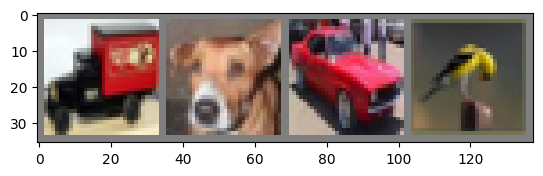

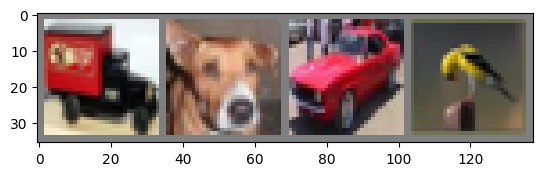

In [50]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [51]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_aug.pt')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4883080404898803, train acc: 0.47071689736223565
 val loss: 1.2475887998621515, val acc: 0.5607491134751774
 learning rate: 0.1

Epoch 1
 train loss: 1.1891328826464944, train acc: 0.5804550796552624
 val loss: 1.1456414785790952, val acc: 0.6071808510638298
 learning rate: 0.1

Epoch 2
 train loss: 1.071158491061418, train acc: 0.6270566727605119
 val loss: 1.110510212309817, val acc: 0.6106826241134753
 learning rate: 0.1

Epoch 3
 train loss: 1.01687993950992, train acc: 0.6443874053277618
 val loss: 0.9939757070642836, val acc: 0.6576241134751774
 learning rate: 0.1

Epoch 4
 train loss: 0.9723770038737239, train acc: 0.6645256594411073
 val loss: 0.9953194932734712, val acc: 0.6554964539007093
 learning rate: 0.1

Epoch 5
 train loss: 0.941399717625142, train acc: 0.6741438691564378
 val loss: 0.9694795600911404, val acc: 0.6692597517730497
 learning rate: 0.1

Epoch 6
 train loss: 0

Посчитайте точность на тестовой выборке:

In [52]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 72.19347133757962 %


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [53]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),  
     transforms.RandomRotation(degrees=10),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name='model_aug_custom.pt')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7118672932305763, train acc: 0.3804558957952468
 val loss: 1.5470536947250366, val acc: 0.43933953900709216
 learning rate: 0.1

Epoch 1
 train loss: 1.4882610940410188, train acc: 0.46546911726299295
 val loss: 1.4288739305861453, val acc: 0.4840868794326241
 learning rate: 0.1

Epoch 2
 train loss: 1.357191438212909, train acc: 0.5146619548184904
 val loss: 1.3588498313376245, val acc: 0.5142287234042553
 learning rate: 0.1

Epoch 3
 train loss: 1.2753284533237408, train acc: 0.547552396186994
 val loss: 1.2501804889516628, val acc: 0.5665336879432625
 learning rate: 0.1

Epoch 4
 train loss: 1.2246290321106013, train acc: 0.5684374183860016
 val loss: 1.221208768448931, val acc: 0.5715425531914894
 learning rate: 0.1

Epoch 5
 train loss: 1.197621599956666, train acc: 0.5764641551318883
 val loss: 1.1403986291682466, val acc: 0.6001994680851064
 learning rate: 0.1

Epoch 6
 train loss:

In [54]:
print("Полученная точность:", test(net, test_loader)[1] * 100,"%")

Полученная точность: 68.1329617834395 %


In [55]:
transforms_list = [
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4), 
  transforms.RandomRotation(degrees=10),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
]

for i, tr in enumerate(transforms_list):
    transform = transforms.Compose([
        tr,
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    train_loader, val_loader, test_loader = get_cifar10_data(
        batch_size=64, transform_train=transform)

    net = BasicBlockNet().to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[10, 15], gamma=0.1)

    tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
        net, optimizer, 20, train_loader, val_loader, scheduler=scheduler, model_name=f'model_aug_custom_{i}.pt')
    
    print(f"Полученная точность на {transform}:", test(net, test_loader)[1] * 100,"%")

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4883080404898803, train acc: 0.47071689736223565
 val loss: 1.2475887998621515, val acc: 0.5607491134751774
 learning rate: 0.1

Epoch 1
 train loss: 1.1891328826464944, train acc: 0.5804550796552624
 val loss: 1.1456414785790952, val acc: 0.6071808510638298
 learning rate: 0.1

Epoch 2
 train loss: 1.071158491061418, train acc: 0.6270566727605119
 val loss: 1.110510212309817, val acc: 0.6106826241134753
 learning rate: 0.1

Epoch 3
 train loss: 1.01687993950992, train acc: 0.6443874053277618
 val loss: 0.9939757070642836, val acc: 0.6576241134751774
 learning rate: 0.1

Epoch 4
 train loss: 0.9723770038737239, train acc: 0.6645256594411073
 val loss: 0.9953194932734712, val acc: 0.6554964539007093
 learning rate: 0.1

Epoch 5
 train loss: 0.941399717625142, train acc: 0.6741438691564378
 val loss: 0.9694795600911404, val acc: 0.6692597517730497
 learning rate: 0.1

Epoch 6
 train loss: 0

Your answers here:

**Our answers here:**

`transforms.RandomCrop()`: Обрезает изображение до заданного размера, сначала расширяя изображение до большего размера и заполняя края, если требуется.

`transforms.RandomRotation()`: Вращает изображение на случайный угол в пределах заданных границ.

`transforms.ColorJitter()`: Случайным образом изменяет яркость, контрастность и насыщенность изображения.


## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [56]:
# <your code here>
import wandb
import datetime

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss_log.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / target.size(0)
        acc_log.append(acc)

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / target.size(0)
        acc_log.append(acc)

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, model_name=None, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}")

        current_lr = optimizer.param_groups[0]['lr']
        print(f" learning rate: {current_lr}\n")

        # Логгирование в wandb
        wandb.log({"Epoch": epoch})
        wandb.log({"Train loss": np.mean(train_loss), "Train accuracy": np.mean(train_acc)})
        wandb.log({"Validation loss": val_loss, "Validation accuracy": val_acc})
        
        if scheduler is not None:
            scheduler.step(val_loss)
        
        if model_name is None:
            model_name = f'model_wb_{datetime.datetime.now()}'


    torch.save(net, model_name)

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [58]:
wandb.init()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, model_name='baseline_wandb.pt')
wandb.finish() 

Epoch 0
 train loss: 0.7780736102918384, train acc: 0.7315593170540612
 val loss: 0.8472977655999204, val acc: 0.7094636524822694
 learning rate: 0.1

Epoch 1
 train loss: 0.7721482441782733, train acc: 0.7335017302167668
 val loss: 0.9139640054804213, val acc: 0.6876329787234042
 learning rate: 0.1

Epoch 2
 train loss: 0.7647050502531272, train acc: 0.7357991642726561
 val loss: 0.9023889067325186, val acc: 0.6993351063829787
 learning rate: 0.1

Epoch 3
 train loss: 0.7559823439587623, train acc: 0.7364439148602768
 val loss: 0.8787974088749987, val acc: 0.7043439716312055
 learning rate: 0.1

Epoch 4
 train loss: 0.7520201304821907, train acc: 0.7409938952729173
 val loss: 0.909047750462877, val acc: 0.6887411347517731
 learning rate: 0.1

Epoch 5
 train loss: 0.7557478068733564, train acc: 0.7374967354400627
 val loss: 0.84628825669593, val acc: 0.7115248226950354
 learning rate: 0.1

Epoch 6
 train loss: 0.745286967244401, train acc: 0.7413652389657874
 val loss: 0.87125430563662

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train accuracy,▁▁▂▂▃▂▃▄▄▄▅▆▆▅▇▇▇▇██
Train loss,██▇▆▆▆▅▅▄▅▃▄▃▃▃▂▂▁▁▁
Validation accuracy,▇▁▄▅▁▇▄▅▇█▇▃▇▇▇▅▆▅▇█
Validation loss,▂█▇▅█▁▄▂▁▁▃▇▁▁▂▅▃▄▁▁
Epoch,19
Train accuracy,0.75824
Train loss,0.69213
Validation accuracy,0.71476
Validation loss,0.84212


Ссылка на полученный report с экспериментом:
https://api.wandb.ai/links/maximelkin14/9dcb0506